# **Code Implementation**

### **Importing libraries**
We beginn by importing  some essential libraries.
Tkinter for GUI, matplotlib.pyplot for visualization, FigureCanvasTkAgg to implement the visualizations into tkinter, NumPy for numeral computation (Arrays, mathematical opertions...) and Scipy.optimize for solving optimization Problems.

In [6]:
import tkinter as tk
from tkinter import ttk, messagebox
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import numpy as np
from scipy.optimize import linprog

We beginn by defining our model class, which we call Linearproram. This class will handle the data of the code and includes all the functions to solve optimization problems. The class constructer consists of objective coefficients,constraints and variables, which are the elements needed, when solving LPP's.

It constists of two main methods. Solve, which handles solving of optimization problems and sensitivity analysis, which calculates shadowprices, slack and allowable increas/decrease.

**Solve Method:**<br>
The method takes in maximize as parameter, which determines the objective of the optimiziation.
In the first line the mimimization is implemented, if the problem is not a maximization problem it will negate the coefficients.

Now the function for parsing variables and constraints will be defined. Constraints will be saved in a Matrix A and the "Right-hand-side" values (RHS) in a vector b. 
Let me break down what happens here:
- We iterate through constraints[]
- values will be split in *right_side* and *left_side* (*a + 0.5*b* <= *3200*) 
- we populate lists A and b with the values from the input
- We maintain clear error handling throughout the whole code, so I wont keep mentioning that

Now we set the lower bound = 0 and upper bound = none for our problems. We decided to code it like that for now, since negativity will rarely be used and due to other priorities.
Then we turn our arrays into ***np.arrays*** for compatibility with ***linprog***.
We solve the problem and save it in the ***res*** variable using the **HiGHS Method (High performance general solver)**, which uses an optimized version of simplex for example and more.

The optimal solution will be saved in ***optimal_value***. Again the results will be adjusted according to the objective max or min and the optimal value (x) as well as the optimal solution will be returned.   

**Sensitivity analysis method:** <br>

*Sensitivity analysis for allowable increase/decrease:*
We start by initializing a String for the result and arrays for sensitivity data.
Then, we go through the same code as before when retriving the user input.

We iterate through each coeffcicient in the objective function vector c.
Now let me break down to you, how we figure out allowable increase and decrease:
- we create 1000 little increments of delta from 0 to 100 (0, 100, 1000)
- we up copy each coefficient and add delta
- we keep solving the problem and gets compared with the original one
- if the change is no longer feasible or it changes significantly, its recorded
- the results are added to the array and formatted for the ui

*Sensitivity analysis for constraints:*
We create arrays *shadow_prices[]* and *slack[]*.
We iterate through them to compute the as follows:
- We create a copy of the RHS-vector b and add/substract for each value 1e-5. (Usually one uses 1, but programming this gives us the oppurtunity to go even smaller, and detect changes with more precision)
- we solve the problems and calculate the change
- we divide the change to normalize it

We calculate the slack as follows:
- slack = rhs value - the scalar of A and the optimal solution
- we use np.dot to put together this scalar while iterating

Finally we save the results in a list, format it for the ui and return the whole sensitivity analysis.

In [7]:
class LinearProgram:
    def __init__(self, objective_coeffs, constraints, variables):
        self.objective_coeffs = np.array(objective_coeffs)
        self.constraints = constraints
        self.variables = variables

    def solve(self, maximize):
        c = self.objective_coeffs if not maximize else -self.objective_coeffs
        A = []
        b = []

        for constraint in self.constraints:
            try:
                    left_side, right_side = constraint.split('<=')
                    rhs = float(right_side.strip())
                    b.append(rhs)
                    terms = left_side.strip().split('+')
                    row = [0] * len(self.variables)
                    for term in terms:
                        coef, var = term.split('*')
                        row[self.variables.index(var.strip())] = float(coef.strip())
                    A.append(row)
            except ValueError:
                raise ValueError(f"Ungültiges Einschränkungsformat: '{constraint}'. Erwartet: 'a1*x1 + a2*x2 <= b'.")
            
        bounds = [(0, None)] * len(self.variables)
        A = np.array(A)
        b = np.array(b)

        res = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method='highs')
        if not res.success:
            raise ValueError("LP konnte nicht gelöst werden.")

        optimal_value = -res.fun if maximize else res.fun
        return res.x, optimal_value

    def sensitivity_analysis(self):
        sensitivity_result = "\n\nSensitivitätsanalyse (Zielfunktionskoeffizienten):\n"
        allowable_increase = []
        allowable_decrease = []

        c = self.objective_coeffs
        A = []
        b = []

        for constraint in self.constraints:
                left_side, right_side = constraint.split('<=')
                rhs = float(right_side.strip())
                b.append(rhs)
                terms = left_side.strip().split('+')
                row = [0] * len(self.variables)
                for term in terms:
                    coef, var = term.split('*')
                    row[self.variables.index(var.strip())] = float(coef.strip())
                A.append(row)

        bounds = [(0, None)] * len(self.variables)
        A = np.array(A)
        b = np.array(b)

        res = linprog(-c, A_ub=A, b_ub=b, bounds=bounds, method='highs')
        if not res.success:
            raise ValueError("LP konnte nicht gelöst werden.")

        for i, original_c in enumerate(c):
            # Allowable Increase
            increase_limit = None
            for delta in np.linspace(0, 100, 1000):
                c_modified = c.copy()
                c_modified[i] = original_c + delta
                res_modified = linprog(-c_modified, A_ub=A, b_ub=b, bounds=bounds, method='highs')
                if not res_modified.success or not np.allclose(res.x, res_modified.x, atol=1e-5):
                    increase_limit = round(delta, 2)
                    break
            # Allowable Decrease
            decrease_limit = None
            for delta in np.linspace(0, 100, 1000):
                c_modified = c.copy()
                c_modified[i] = original_c - delta
                res_modified = linprog(-c_modified, A_ub=A, b_ub=b, bounds=bounds, method='highs')
                if not res_modified.success or not np.allclose(res.x, res_modified.x, atol=1e-5):
                    decrease_limit = round(delta, 2)
                    break

            allowable_increase.append(increase_limit)
            allowable_decrease.append(decrease_limit)
            sensitivity_result += (f"Variable {self.variables[i]}: Erlaubte Erhöhung = {increase_limit}, Erlaubte Verringerung = {decrease_limit}\n")
        # Sensitivity analysis for constraints
        sensitivity_result += "\nSensitivitätsanalyse (Restriktionsgrenzen):\n"

        shadow_prices = []
        slacks = []
        for i in range(len(b)):
            # Calculate shadow prices
            modified_b_increase = b.copy()
            modified_b_increase[i] += 1e-5
            res_increase = linprog(-c, A_ub=A, b_ub=modified_b_increase, bounds=bounds, method='highs')

            modified_b_decrease = b.copy()
            modified_b_decrease[i] -= 1e-5
            res_decrease = linprog(-c, A_ub=A, b_ub=modified_b_decrease, bounds=bounds, method='highs')

            shadow_price = (res_increase.fun - res_decrease.fun) / 2e-5 if res_increase.success and res_decrease.success else 0
            slack = b[i] - np.dot(A[i], res.x) if res.success else 0

            shadow_prices.append(round(shadow_price, 2))
            slacks.append(round(slack, 2))
            sensitivity_result += (f"Einschränkung {i + 1}: Schattengrenze = {round(shadow_price, 2)}, Slack = {round(slack, 2)}\n")

        return sensitivity_result

## **View**

We continue with the Appview class, which inherits from Tkinter to create a GUI and takes as a parameter the controller class.

Here a quick breakdown of the methods:

**setup_scrollable_widgets**
- Creates a scrollable container using a Canvas and Scrollbar for better navigation.

**setup_widgets**
- Defines all input fields, buttons, output areas, and chart sections for the GUI.

**lock_input_fields**
- Disables input fields and enables buttons for editing (Change) and resetting (Reset Changes).
- Prevents accidental modification after running the analysis.

**enable_editing**
- Unlocks the fields for editing decision variables, coefficients, and constraints.

**reset_changes**
- Clears all edits and resets the editable fields to their initial state.
- Removes generated charts from the chart_canvas.

**update_output**
- Clears the current output text area.

**plot_comparison**
- Generates a bar chart comparing the original and modified solutions for decision variables.

**plot_sensitivity_analysis**
- Creates a line plot comparing original and modified objective coefficients.
Uses labeled axes and legends to visualize sensitivity analysis results clearly.

In [8]:
class AppView(tk.Tk):
    def __init__(self, controller):
        super().__init__()
        self.controller = controller
        self.title("LP Sensitivity Analysis")
        self.geometry("800x800")

        #self.setup_widgets()

        self.setup_scrollable_widgets()

    def setup_scrollable_widgets(self):
        # Create a Frame for scrollable content
        container = ttk.Frame(self)
        container.pack(fill="both", expand=True)

        # Create a Canvas and Scrollbars
        self.canvas = tk.Canvas(container)
        scrollbar_y = ttk.Scrollbar(container, orient="vertical", command=self.canvas.yview)
        scrollbar_x = ttk.Scrollbar(container, orient="horizontal", command=self.canvas.xview)

        self.canvas.configure(yscrollcommand=scrollbar_y.set, xscrollcommand=scrollbar_x.set)

        # Pack the Canvas and Scrollbars
        self.canvas.grid(row=0, column=0, sticky="nsew")
        scrollbar_y.grid(row=0, column=1, sticky="ns")
        scrollbar_x.grid(row=1, column=0, sticky="ew")

        # Configure the container to stretch properly
        container.grid_rowconfigure(0, weight=1)
        container.grid_columnconfigure(0, weight=1)

        # Create a Frame inside the Canvas for widgets
        self.scrollable_frame = ttk.Frame(self.canvas)
        self.scrollable_frame.bind("<Configure>", lambda e: self.canvas.configure(scrollregion=self.canvas.bbox("all")))

        # Add the Frame to the Canvas
        self.canvas.create_window((0, 0), window=self.scrollable_frame, anchor="nw")

        # Populate scrollable frame with widgets
        self.setup_widgets()


    def setup_widgets(self):
        # Input Frame
        input_frame = ttk.LabelFrame(self.scrollable_frame, text="Input")
        input_frame.pack(fill="x", padx=10, pady=5)

        ttk.Label(input_frame, text="Decision variables (comma-separated, e.g., 'x1, x2'):").grid(row=0, column=0, padx=5, pady=5)
        self.variables_entry = ttk.Entry(input_frame, width=40)
        self.variables_entry.grid(row=0, column=1, padx=5, pady=5)

        ttk.Label(input_frame, text="Objective coefficients (comma-separated):").grid(row=1, column=0, padx=5, pady=5)
        self.obj_coeffs_entry = ttk.Entry(input_frame, width=40)
        self.obj_coeffs_entry.grid(row=1, column=1, padx=5, pady=5)

        ttk.Label(input_frame, text="Constraints (one per line, e.g., 'x1 + x2 <= 10'):").grid(row=2, column=0, padx=5, pady=5)
        self.constraints_text = tk.Text(input_frame, height=5, width=40)
        self.constraints_text.grid(row=2, column=1, padx=5, pady=5)

        self.maximize_button = ttk.Button(input_frame, text="Maximize", command=lambda: self.controller.run_analysis(maximize=True))
        self.maximize_button.grid(row=3, column=0, pady=10)
        self.minimize_button = ttk.Button(input_frame, text="Minimize", command=lambda: self.controller.run_analysis(maximize=False))
        self.minimize_button.grid(row=3, column=1, pady=10)

        self.change_button = ttk.Button(input_frame, text="Change", command=self.enable_editing, state="disabled")
        self.change_button.grid(row=4, column=0, columnspan=2, pady=10)

        ttk.Label(input_frame, text="Edit decision variables:").grid(row=5, column=0, padx=5, pady=5)
        self.edit_variables_entry = ttk.Entry(input_frame, width=40, state="disabled")
        self.edit_variables_entry.grid(row=5, column=1, padx=5, pady=5)

        ttk.Label(input_frame, text="Edit Objective Coefficients:").grid(row=6, column=0, padx=5, pady=5)
        self.edit_obj_coeffs_entry = ttk.Entry(input_frame, width=40, state="disabled")
        self.edit_obj_coeffs_entry.grid(row=6, column=1, padx=5, pady=5)

        ttk.Label(input_frame, text="Edit Constraints:").grid(row=7, column=0, padx=5, pady=5)
        self.edit_constraints_text = tk.Text(input_frame, height=5, width=40, state="disabled")
        self.edit_constraints_text.grid(row=7, column=1, padx=5, pady=5)

        self.compare_button = ttk.Button(input_frame, text="Compare", command=self.controller.compare_solutions, state="disabled")
        self.compare_button.grid(row=8, column=0, columnspan=2, pady=10)

        # Neuer Reset Changes Button
        self.reset_button = ttk.Button(input_frame, text="Reset Changes", command=self.reset_changes, state="disabled")
        self.reset_button.grid(row=9, column=0, columnspan=2, pady=10)

        # Output Frame
        output_frame = ttk.LabelFrame(self.scrollable_frame, text="Output")
        output_frame.pack(fill="both", expand=True, padx=10, pady=5)

        self.output_text = tk.Text(output_frame, height=10)
        self.output_text.pack(fill="both", expand=True, padx=5, pady=5)

        # Chart Frame
        chart_frame = ttk.LabelFrame(self.scrollable_frame, text="Charts")
        chart_frame.pack(fill="both", expand=True, padx=10, pady=5)

        self.chart_canvas = tk.Canvas(chart_frame)
        self.chart_canvas.pack(fill="both", expand=True, padx=5, pady=5)

    def lock_input_fields(self):
        self.variables_entry.config(state="disabled")
        self.obj_coeffs_entry.config(state="disabled")
        self.constraints_text.config(state="disabled")
        self.change_button.config(state="normal")
        self.maximize_button.config(state="disabled")
        self.minimize_button.config(state="disabled")
        self.reset_button.config(state="disabled")  # Reset-Button aktivieren

    def enable_editing(self):
        self.edit_variables_entry.config(state="normal")
        self.edit_obj_coeffs_entry.config(state="normal")
        self.edit_constraints_text.config(state="normal")
        self.change_button.config(state="disabled")
        self.compare_button.config(state="normal")
        self.reset_button.config(state="normal")

    def reset_changes(self):
        self.edit_variables_entry.delete(0, tk.END)
        self.edit_obj_coeffs_entry.delete(0, tk.END)
        self.edit_constraints_text.delete("1.0", tk.END)
        self.variables_entry.config(state="normal")
        self.obj_coeffs_entry.config(state="normal")
        self.constraints_text.config(state="normal")
        self.edit_variables_entry.config(state="disabled")
        self.edit_obj_coeffs_entry.config(state="disabled")
        self.edit_constraints_text.config(state="disabled")
        self.maximize_button.config(state="normal")
        self.minimize_button.config(state="normal")
        self.compare_button.config(state="disabled")
        self.reset_button.config(state="disabled")   # Reset-Button deaktivieren

        # Entferne die Grafik
        for widget in self.chart_canvas.winfo_children():
            widget.destroy()

    def update_output(self, results):
        self.output_text.delete("1.0", tk.END)
        self.output_text.insert(tk.END, results)
    
    #def plot_comparison(self, original_solution, original_value, new_solution, new_value):
     #   figure, ax = plt.subplots()
     #   x_labels = [f"{var}" for var in self.controller.model.variables]
     #   x = np.arange(len(x_labels))

     #   ax.bar(x - 0.2, original_solution, 0.4, label="Original Solution")
     #   ax.bar(x + 0.2, new_solution, 0.4, label="New Solution")

    #    ax.set_xticks(x)
     #   ax.set_xticklabels(x_labels)
     #   ax.set_ylabel("Values")
     #   ax.set_title("Solution Comparison")
     #   ax.legend()

      #  canvas = FigureCanvasTkAgg(figure, master=self.chart_canvas)
      #  canvas.draw()
     #   canvas.get_tk_widget().pack(fill="both", expand=True)
    
    def plot_sensitivity_analysis(self, original_coeffs, new_coeffs):
        """Zeichnet ein Liniendiagramm, das die originalen und neuen Zielfunktionskoeffizienten vergleicht."""
        figure, ax = plt.subplots()

        x_labels = [f"{var}" for var in self.controller.model.variables]
        x = np.arange(len(x_labels))

        ax.plot(x, original_coeffs, marker='o', label="Original Coefficients")
        ax.plot(x, new_coeffs, marker='x', linestyle='--', label="New Coefficients")

        ax.set_xticks(x)
        ax.set_xticklabels(x_labels)
        ax.set_ylabel("Coefficient Values")
        ax.set_title("Sensitivity Analysis: Objective Coefficients")
        ax.legend()

        canvas = FigureCanvasTkAgg(figure, master=self.chart_canvas)
        canvas.draw()
        canvas.get_tk_widget().pack(fill="both", expand=True)

    def plot_solution_bar_comparison(self, original_solution, original_value, new_solution, new_value):
        """Zeichnet ein Balkendiagramm, das die originalen und neuen optimalen Lösungen vergleicht."""
        figure, ax = plt.subplots()

        x_labels = [f"{var}" for var in self.controller.model.variables]
        x = np.arange(len(x_labels))

        # Balkendiagramm für Lösungen
        bar_width = 0.35
        ax.bar(x - bar_width / 2, original_solution, bar_width, label=f"Original Solution (Value: {round(original_value, 2)})")
        ax.bar(x + bar_width / 2, new_solution, bar_width, label=f"New Solution (Value: {round(new_value, 2)})")

        ax.set_xticks(x)
        ax.set_xticklabels(x_labels)
        ax.set_ylabel("Values")
        ax.set_title("Optimal Solution Bar Comparison")
        ax.legend()

        # Canvas in der GUI anzeigen
        canvas = FigureCanvasTkAgg(figure, master=self.chart_canvas)
        canvas.draw()
        canvas.get_tk_widget().pack(fill="both", expand=True)
  

***Controller***

This code defines the AppController class, which is designed as the Controller in a Model-View-Controller (MVC) architecture for solving and visualizing linear programming (LP) problems. 
The primary responsibility of the AppController is to handle the flow of data between the Model (which defines the LP problem and solves it) and the View (which handles the user interface).

The controller facilitates the creation of linear programming models, manages user input, performs computations like solving the optimization problem, and updates the view with results. 
The controller also includes a plotting function for visualizing the feasible region of a linear programming problem. However, this method is currently placed here for temporary use, as it is intended to be integrated into the View in the final version of the application.

**Controller Overview**
- The AppController class acts as the controller in the MVC architecture, handling the interaction between the user (through the view) and the model (which solves the linear programming problem).
- The __init__ method initializes the controller, setting up the model, view, and storage for the original solution, optimal value, and coefficients.
- The run() method starts the event loop of the GUI by calling self.view.mainloop().

**Plotting the Feasible Region**
- The plot_feasible_region method is used to visualize the constraints, feasible region, and optimal solution on a plot. This method is currently placed in the AppController for temporary purposes. 
  Eventually, it will be moved to the View component to better align with the MVC structure.

**Running the Analysis**
- The run_analysis method is responsible for gathering input from the user (such as decision variables, objective coefficients, and constraints), constructing the linear programming model, solving it, and updating the output in the view.
- The method also handles both maximization and minimization LP problems, updating the GUI with the results, and locking input fields once the solution has been computed.
- Additionally, it calls the plot_feasible_region method (temporarily located in the controller) to visualize the problem's feasible region.

**Comparing Solutions**
- The compare_solutions method allows the user to compare the current solution with a new one. 
  The user can modify the objective coefficients or constraints, and the method will solve the new model and show the comparison between the original and new solutions.
- This method also plots sensitivity analysis to show how changes in the coefficients affect the optimal solution(works, but more to come).

**Error Handling**
- We tried to design our application with error handling in mind, thats why we implemented that whenever an eeor occurs during input processing, solving or visualization, a message is shown in the interface using **messagebox.showerror**

In [9]:
class AppController:
    def __init__(self):
        self.model = None
        self.view = AppView(self)
        self.original_solution = None
        self.original_value = None
        self.original_coeffs = None

    def run(self):
        self.view.mainloop()

    def run_analysis(self, maximize):
        try:
            # Parse inputs
            variables = [var.strip() for var in self.view.variables_entry.get().split(',')]
            obj_coeffs = list(map(float, self.view.obj_coeffs_entry.get().split(',')))
            constraints = [line.strip() for line in self.view.constraints_text.get("1.0", tk.END).splitlines() if line.strip()]

            # Initialize model
            self.model = LinearProgram(obj_coeffs, constraints, variables)

            # Solve the LP
            solution, optimal_value = self.model.solve(maximize)



            # Perform sensitivity analysis
            results = f"Optimale Lösung: {dict(zip(variables, map(lambda x: round(x, 2), solution)))}, Optimaler Wert: {round(optimal_value, 2)}\n"
            results += self.model.sensitivity_analysis()

            # Save original solution
            self.original_solution = solution
            self.original_value = optimal_value
            self.original_coeffs = obj_coeffs

            # Update view
            self.view.lock_input_fields()
            self.view.update_output(results)


        except Exception as e:
            messagebox.showerror("Error", str(e))

    def compare_solutions(self):
        try:
            # Parse new inputs
            variables = [var.strip() for var in self.view.edit_variables_entry.get().split(',')]
            obj_coeffs = list(map(float, self.view.edit_obj_coeffs_entry.get().split(',')))
            constraints = [line.strip() for line in self.view.edit_constraints_text.get("1.0", tk.END).splitlines() if line.strip()]

            # Initialize new model
            new_model = LinearProgram(obj_coeffs, constraints, variables)

            # Solve the new LP
            new_solution, new_value = new_model.solve(maximize=True)

            # Plot bar comparison
            self.view.plot_solution_bar_comparison(self.original_solution, self.original_value, new_solution, new_value)

            # Update view with comparison
         #   self.view.plot_comparison(self.original_solution, self.original_value, new_solution, new_value)

            # Plot sensitivity analysis
            self.view.plot_sensitivity_analysis(self.original_coeffs, obj_coeffs)

            

        except Exception as e:
            messagebox.showerror("Error", str(e))



In [ ]:
if __name__ == "__main__":
    app = AppController()
    app.run()

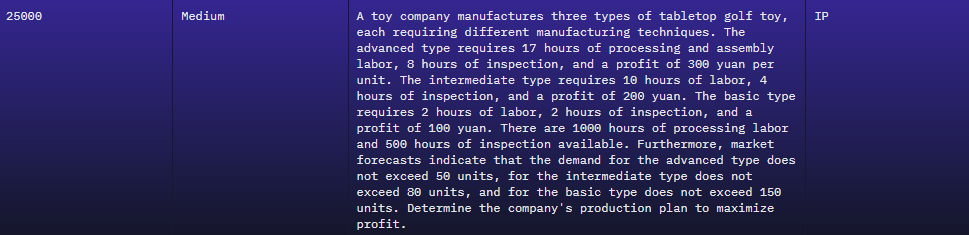

**1. Beispiel**
en_answer: 25000
difficulty: Medium
en_question: A toy company manufactures three types of tabletop golf toy, each requiring different manufacturing techniques. The advanced type requires 17 hours of processing and assembly labor, 8 hours of inspection, and a profit of 300 yuan per unit. The intermediate type requires 10 hours of labor, 4 hours of inspection, and a profit of 200 yuan. The basic type requires 2 hours of labor, 2 hours of inspection, and a profit of 100 yuan. There are 1000 hours of processing labor and 500 hours of inspection available. Furthermore, market forecasts indicate that the demand for the advanced type does not exceed 50 units, for the intermediate type does not exceed 80 units, and for the basic type does not exceed 150 units. Determine the company's production plan to maximize profit.
question_type: IP

300*a+200*b+100*c=Z
17*a+10*b+2*c<=1000
8*a+4*b+2*c<=500
1*a<=50
1*b<=80
1*c<=150

**2. Beispiel**
a,b
3,4
1*a<=40
1*b<=60
2*a+1*b<=100

1*x1+1*y1=100
1*x2+1*y2=200
1*x1<=80
1*x2<=150
1*y1<=120
1*y2<=100